# Reconhecimento facial
<small> Guilherme Monteiro e Vinícius Cavalcante <small>

Neste Notebook será feito um classificador SVM com kernel Gaussiano. Para isso, primeiro será organizado o dataset, projetadas as características de nosso dataset utilizando o PCA desenvolvido e treinado o classificador.

In [28]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import matplotlib.pyplot as plt
import html
import pandas as pd
from google.colab import files
import os
from datetime import timedelta

# SVM

Um classificador por vetores de suporte (*Support Vector Machine* - SVM) procura dividir o espaço das variáveis explicativas - ou um mapa alternativo deste espaço - em duas (ou mais) regiões separadas por um hiperplano (um plano em múltiplas dimensões).

Treinar o  modelo SVM usando Kernel gaussiano possui várias etapas:
* Gerar um dataset de entradas (`patients_data`, imagens) e saídas (`patients_target`, números de 0 a 2, para classificação) utilizando os dados das imagens do treino. Além disso, você precisa de uma lista `patients_target_pain`, para depois ligar o nível de dor aos números de classificação;
* Dividir os dados em treino e teste. Verificar se alguns pacientes, que possuem poucas fotos, não ficaram somente em um grupo;
* Treinar o modelo SVM, utilizando o `GridSearchCV` para ajuste de hiperperâmetros e utilizar kernel Gaussiano;
* Analisar a performance do modelo, plotando, por exemplo, a matriz de confusão.




## As imagens

O código abaixo serve para gerar um diretório local, com todas as fotos dos pacientes já na dimensão correta de 62 x 47 em pastas separadas por nível de dor. Deve-se gerar os datasets de entrada e saída.

In [29]:
#Import modules
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

O nome do diretório é Files

In [30]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

patients_target_pain = os.listdir('gdrive/Shareddrives/TCC_MLR-Guilherme_Vinicius/Notebooks/Files/Train')
print(patients_target_pain)

Mounted at /content/gdrive
['Baixo', 'Medio', 'Alto']


In [31]:
#patients_target_pain.remove('.ipynb_checkpoints')
n_classes = len(patients_target_pain)
print(f'Nosso problema terá {n_classes} classes.')

Nosso problema terá 3 classes.


In [32]:
basedir = 'gdrive/Shareddrives/TCC_MLR-Guilherme_Vinicius/Notebooks/Files/Train/'

In [33]:
!ls gdrive/Shareddrives/TCC_MLR-Guilherme_Vinicius/Notebooks/Files/Train

Alto  Baixo  Medio


In [34]:
with_resize = False
if with_resize:
  resize, altura_lfw, largura_lfw = 0.5, 62, 47
else:
  resize, altura_lfw, largura_lfw = 1, 125, 94

patients_data = []
patients_target = []
for i in range(len(patients_target_pain)):
  included_extensions = ['jpg','jpeg']
  imagens = [fn for fn in os.listdir(basedir+patients_target_pain[i]+'/')
              if any(fn.endswith(ext) for ext in included_extensions)]
  for j in range(len(imagens)):
    img = cv2.imread('{0}/{1}/{2}'.format(basedir,patients_target_pain[i],imagens[j]), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (largura_lfw, altura_lfw), interpolation=cv2.INTER_CUBIC)
    patients_data.append(img.reshape(1,-1)[0])
    patients_target.append(i)

Os dados de entrada são `patients_data` com número de linhas coincidente com número total de imagens por 2914 colunas (cada coluna uma característica da imagem). Os dados de saída estão armazenados no dataset `patients_target`, que tem dimensão número total de imagens, cada linha é um número inteiro que pode variar entre 0-2 (cada número representa um nível de dor).


In [35]:
patients_data = np.array(patients_data)
patients_target = np.array(patients_target)
print(patients_data.shape)
print(patients_target.shape)

(1242, 11750)
(1242,)


In [36]:
print(patients_target)

[0 0 0 ... 2 2 2]



Porém, serão utilizadas as componentes principais para diminuir a dimensão do problema.

Para tanto, é preciso fazer upload das componentes salvas com o fechamento do notebook anterior.

In [37]:
from sklearn.decomposition import PCA
import pickle as pk

In [38]:
pca = pk.load(open('gdrive/Shareddrives/TCC_MLR-Guilherme_Vinicius/Notebooks/Files/pca_'+str(resize)+'.pkl', 'rb'))

## Divisão do dataset e projeção nas Componentes Principais

Inicialmente, deve-se dividir o conjunto de dados em treino e validação. Para isso, será usado `train_test_split`, da `sklearn`.

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(patients_data, patients_target, test_size=0.2, random_state=48)

Depois, projetadas nas direções principais.

In [40]:
X_train_pc = pca.transform(X_train)
X_test_pc = pca.transform(X_test)

In [41]:
print(y_test)

[1 1 2 0 1 1 2 1 1 1 1 1 0 1 1 1 1 1 2 1 1 1 1 2 1 2 2 1 2 1 2 2 1 2 0 1 1
 1 1 2 1 1 1 2 0 2 2 1 0 0 1 1 2 0 2 0 1 1 2 1 1 1 0 1 1 1 0 0 1 0 1 0 1 1
 1 2 1 0 1 1 1 2 1 1 2 0 0 0 1 2 1 1 0 2 0 0 1 1 0 1 1 0 1 1 1 2 2 1 0 0 2
 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 2 1 1 1 1 0 1 2 0 1 2 1 0 1 1 2 1 1 0 1 1 2
 1 2 1 2 2 2 1 0 2 1 1 1 0 2 0 1 1 1 2 0 1 2 2 2 0 1 1 1 1 1 0 1 1 0 1 1 0
 1 2 0 1 1 0 1 2 1 1 0 2 1 1 1 0 1 1 0 1 1 2 1 2 1 1 2 2 2 0 2 2 1 1 1 1 2
 1 1 1 1 1 1 1 1 1 0 2 0 1 1 0 2 1 2 1 0 0 0 1 0 0 2 1]


## Treinamento do Modelo

Agora vamos treinar o modelo de Classificação SVM com o kernel Radial Basis Function (RBF ou Gaussiana), 
$$
\exp(-\gamma \|x-x'\|^2)
$$

Nesse caso, dois parâmetros devem ser considerados: $C$ e $\gamma$. O parâmetro $C$, comum a todos os kernels SVM, é o parâmetro para uso de *margem soft*, balanceando o compromisso entre a classificação correta de exemplos de treinamento contra a maximização da margem da função de decisão. Um $C$ baixo torna a superfície de decisão suave, enquanto um $C$ alto visa classificar todos os exemplos de treinamento corretamente. $\gamma$ é o inverso da variância define a influência de um único exemplo de treinamento. Um $\gamma$ pequeno significa uma gaussiana com uma grande variância, então a influência de $x'$ é maior, ou seja, se  $x'$ é um vetor de suporte, um $\gamma$ pequeno implica que a classe desse vetor de suporte terá influência na decisão da classe do vetor $x$ mesmo que o distância entre eles seja grande. Se $\gamma$ é grande, então a variância é pequena, o que implica que o vetor de suporte não tem influência generalizada. Tecnicamente falando, $\gamma$ grande leva a modelos de alta viés e baixa variância e vice-versa.

Será usado `GridSearchCV`, módulo do `sklearn` para o ajuste dos hiperparâmetros $C$ e $\gamma$. O objetivo primário do GridSearchCV é a criação de combinações de parâmetros para posteriormente avaliá-las. A maneira de acessar os resultados é a partir do atributo `.cv_results_`, sendo que o melhor estimador é definido em `clf.best_estimator`.

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

In [43]:
print('Definição dos melhores hiperparâmetros\n Classificador SVM com kernel gaussiano')
scoring = ['accuracy','f1_macro']
param_grid = {
         'C': [1, 5, 10, 15, 25, 50, 0.1e3, 0.25e3, 0.5e3, 1e3, 2.5e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.00025, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
#It will only optimize the scorer present in refit. 
#So in above code, the accuracy is being optimized. f1 is just monitored.           
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, 
                   scoring=scoring, refit='accuracy', return_train_score=True,cv =3)
clf = clf.fit(X_train_pc, y_train)
print("Melhor estimador encontrado:")
print(clf.best_estimator_)

Definição dos melhores hiperparâmetros
 Classificador SVM com kernel gaussiano
Melhor estimador encontrado:
SVC(C=10, class_weight='balanced', gamma=0.005)


In [44]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [45]:
y_pred = clf.predict(X_test_pc)

In [46]:
print(classification_report(y_test, y_pred, target_names=patients_target_pain))

              precision    recall  f1-score   support

       Baixo       0.96      0.85      0.90        54
       Medio       0.89      0.96      0.93       140
        Alto       0.94      0.85      0.90        55

    accuracy                           0.92       249
   macro avg       0.93      0.89      0.91       249
weighted avg       0.92      0.92      0.92       249



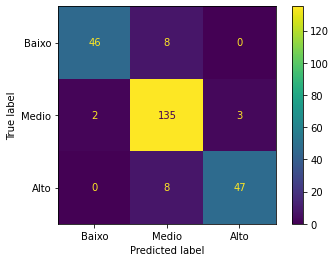

In [47]:
cf_matrix = confusion_matrix(y_test, y_pred, labels=range(n_classes))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = patients_target_pain)

cm_display.plot()
plt.show()

In [48]:
correct = []
incorrect = []
for i in range(len(y_test)):
  pred_pain = patients_target_pain[y_pred[i]].rsplit('_', 1)[-1]
  true_pain = patients_target_pain[y_test[i]].rsplit('_', 1)[-1]
  if pred_pain == true_pain:
    correct.append(i)
  else:
    incorrect.append(i)
correct = np.array(correct)
incorrect = np.array(incorrect)
n_correct = correct.shape[0]
n_incorrect = incorrect.shape[0]
print(f'{n_correct} classificados corretamente')
print(f'{n_incorrect} classificados incorretamente')

228 classificados corretamente
21 classificados incorretamente


In [49]:
n_columns = 3
n_rows = np.ceil(n_incorrect/n_columns)

'''plt.figure(figsize=(1.8 * n_columns, 2.4 * n_rows)) 
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)

for j in range(n_incorrect):
    i = incorrect[j]
    plt.subplot(n_rows,n_columns,j+1) 
    plt.imshow(X_test[i].reshape((altura_lfw, largura_lfw)), cmap='gray')
    plt.title('prev: %s\nreal: %s' % (patients_target_pain[y_pred[i]].rsplit('_', 1)[-1], patients_target_pain[y_test[i]].rsplit('_', 1)[-1]))
    plt.xticks(())
    plt.yticks(())
plt.show()'''

"plt.figure(figsize=(1.8 * n_columns, 2.4 * n_rows)) \nplt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)\n\nfor j in range(n_incorrect):\n    i = incorrect[j]\n    plt.subplot(n_rows,n_columns,j+1) \n    plt.imshow(X_test[i].reshape((altura_lfw, largura_lfw)), cmap='gray')\n    plt.title('prev: %s\nreal: %s' % (patients_target_pain[y_pred[i]].rsplit('_', 1)[-1], patients_target_pain[y_test[i]].rsplit('_', 1)[-1]))\n    plt.xticks(())\n    plt.yticks(())\nplt.show()"

# Salvando o modelo

In [50]:
import pickle as pk

In [51]:
!mkdir -p gdrive/Shareddrives/TCC_MLR-Guilherme_Vinicius/Notebooks/Files/

In [52]:
with open('gdrive/Shareddrives/TCC_MLR-Guilherme_Vinicius/Notebooks/Files/model_clf_SVM_Gaussiano_'+str(resize)+'.sav', 'wb') as pickle_file:
   pk.dump(clf, pickle_file)